# Description

The task is to compare the performance of classic ML models, Random Forest (RF), Support Vector Machine (SVM) and k-nearest neighbours algorithm (kNN) for multiclass classification of the complex boreal landscape using data from forest inventory data represented by plots. Each sample (a record) is the combination of spectral data (bands and derivatives) with terrain features assimilated pixel-wise.

**Briefly**: performance of the models is evaluated by 5 fits for each model on random* train/test data. Models efficiency is evaluated using Kruskal–Wallis test by comparing average macro F1 scores for filtered and non-filtered data.

*see description below

<br>


The structure of this notebook is the following:
1) description
2) libraries upload (data analysis, clustering, ML models, statistics, visualisation support and resulting models saving)
3) data upload
4) setting of helpers functions:

* functions for data filtering (``get_cluster_pixels``, ``get_selection``) according to KMeans clusterisation results -- only data belonging to the dominant cluster is selected (see more in utils.py file and "Clustering" notebook)
* function to get predictions (``get_predictions``) for optimisation of random train/test split and hyperparameters. This function considers the following problems of the label data from inventories used for ML:

a) problem of overlapping the data from the same inventory plot in train and test. This must be avoided to reduce the possibility of overfitting. Thus, splitting using groups (by key) is used. As a result, in train and test data, there are no records with the duplicate keys (meaning from the same inventory plot) 

b) problem of missing classes. After train/test splitting, all classes must be represented in both parts of the data. To achieve this, a while-condition is added: train/test split is performed until the number of unique classes in train data is equal to the number of unique classes in test data, and these numbers are equal to the number of unique classes in the initial dataset. As a result, all classes are included in train and test data. 

c) problem of unbalanced data -- different classes is represented by different numbers of the records. Thus, SMOTE oversampling technique is used with a fixed random state. As a result, all classes are resampled to the dominant class number of pixels (records/samples).

d) problem of unsuitable hyperparameters. For this search, the random grid space is used. Grid spaces are built for each model with main hyperparameters that should be considered.

As a result of the whole step, a model variation with the best hyperparameters is selected. The function returns the best model fit, test dataset, corresponding labels and predictions of labels as a list.

* function with metric descriptions (``metrics_description``): average and class-specified F1 score, precision and recall, average total accuracy and Kappa scores. The function is supplied with a confusion matrix plot (shown when the option is chosen as ``True``). All metrics are obtained for test data. 
* function for getting metrics **by classes** (``get_classes_metrics``) for each launch of model fit (for test data). As a result, the function returns a dataset with the number of launches, name of the class, F1 score, precision, and recall as columns.
* function for getting **average metrics** (``get_metrics_average``) for each launch of model fit (for test data).

5) data filtration using clustering procedure
6) models built using random search CV and SMOTE options on filtered and non-filtered data
* getting models fits for 5 random iteration
* getting metrics -- average and by classes
* plotting by class metrics distributions as boxplots
7) getting statistics for the performance evaluation

# Libraries

In [1]:
#libraries


import pandas as pd
import geopandas as gpd
import numpy as np


#clustering
from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from yellowbrick.cluster import KElbowVisualizer
#for PCA option
from sklearn.decomposition import PCA

#test/train split and hyperparameters optimisation
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit


#ML
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, cohen_kappa_score 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#stats
import scipy.stats

#visuals
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(['science', 'no-latex']) 
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update({
    "font.family": "serif",   
    "font.serif": ["Times"],  
    "font.size":9,
    "axes.labelsize":9,
    "xtick.labelsize" : 9,
    "ytick.labelsize" : 9})   
colors =[
    '#117733',
    '#50CE57',
    '#23A28F',
    '#5BD0AE',
    '#88CCEE', #water
    '#92462D', #soil
    '#DE7486',
    '#DDCC77',
    '#AA4499',
    '#0f62fe',
    '#be95ff'
]


#model saving
from joblib import dump, load

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
df = pd.read_csv('scalled_data_full.csv', index_col=0)

# Helpers

In [4]:
#for data filtering
from utils import get_cluster_pixels, get_selection

In [5]:
#for getting predictions
def get_predictions(data, 
                    model,
                    param_grid, 
                    cv: int=5, 
                    n_iter_search: int=3):
    #test/train spliting considering key overlap problems and missed classes
    while True:
        train_inds, test_inds = next(GroupShuffleSplit(test_size=.25, 
                                                   n_splits=2#,random_state = 40
                                                      ).split(data, groups=data['key']))
        #because we need pixels from same plots to be separated in train and test

        train = data.iloc[train_inds]
        test = data.iloc[test_inds]
        if len(train['class'].unique(
        )) == len(test['class'].unique(
        )) == len(filtered_df_a['class'].unique()): #because we need classes to be represented in train and test
            break
            
    #function to be sure that keys in train and data are not the same
    #if bool(set(test['key']) & set(train['key'])):
    #    print('Dubles in train and test')
    #else: print('No dubles found')  

    #class balansing with smote
    smote = SMOTE(random_state = 42)
    X, y = smote.fit_resample(train.iloc[:,:-2], train['class'])
    df_smote = pd.DataFrame(X, columns = train.iloc[:,:-2].columns.tolist())


    #we set train Xy from SMOTE results
    X_train = df_smote
    y_train = y
    X_test = test.iloc[:,:-2]   
    y_test = test['class']
    
    #parameters optimisation
    
    gs = RandomizedSearchCV(model, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'accuracy')
    gs.fit(X_train, y_train)  
    y_pred = gs.best_estimator_.predict(X_test)
    model_fit = gs.best_estimator_

    return model_fit, X_test, y_test, y_pred

In [6]:
def metrics_description(y_true, y_pred, confusion_matrix_on: bool=True):
    dict_normal_names={7: "Pine", 
        5:"Aspen",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body',
        17:'Settlements'}
    
    print('Accuracy score: %.2f%%' %(accuracy_score(y_true, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_true, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_true, y_pred, average= 'weighted')*100))
    print('F1-Score: %.2f%%'%(f1_score(y_true, y_pred, average = 'macro')*100))
    print('Kappa score: %.2f%%'%(cohen_kappa_score(y_true, y_pred)*100))
    
    
    #dataframe with metrics by class
    metrics_by_class = pd.DataFrame(
            {
                'names': list(map(dict_normal_names.get, list(np.unique(y_true)))),
                'f1_scores': f1_score(y_true, y_pred,
                           average=None).round(2).tolist(),
                'precision_list': precision_score(y_true, y_pred, 
                                   average=None).round(2).tolist(),
                'recall':recall_score(y_true, y_pred,
                                   average=None).round(2).tolist()
            }
        )
    display(metrics_by_class)
    
    #confusion matrix
    if confusion_matrix_on is True:
        data = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(data, columns=list(map(dict_normal_names.get, list(np.unique(y_true)))), 
                             index = list(map(dict_normal_names.get, list(np.unique(y_true)))))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'

        #confusion matrix plot
        f, ax = plt.subplots(figsize=(6, 10))
        cmap = sns.cubehelix_palette(light=1, as_cmap=True)

        sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                    annot_kws={'size': 10})
        plt.title('Actuals vs Predicted')
        plt.show()

In [81]:
#getting dataset with metrics by class for each random prediction
def get_classes_metrics(models_vector): #vector with model variations, y predicted and y true from the dataset
    class_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:

        dict_normal_names={7: "Pine",  
            5:"Aspen",
            1:"Birch",
            6:"Silver fir",
            15:"Burnt forest", 
            13:'Deforestation', 
            14:'Grass',
            12:'Soil', 
            16:'Swamp', 
            11:'Water body',
            17:'Settlements'}

        count += 1 #counting
        pred = i[2] #predicted values from random train set
        true = i[3] #corresponding values from random test set
        names_list = list(np.unique(true))

        temp = pd.DataFrame(
            {
                'iteration':[count]*len(names_list), 
                'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average=None).round(2).tolist(),
                'precision_list': precision_score(true, 
                                   pred, 
                                   average=None).round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average=None).round(2).tolist()
            }
        ) #dataset for each model 

        class_metrics_dataframe = pd.concat([class_metrics_dataframe, temp], ignore_index=True)
    return class_metrics_dataframe    

In [34]:
#getting dataset with average metrics for each random prediction
def get_metrics_average(models_vector): #vector with model variations, y predicted and y true from the dataset
    average_metrics_dataframe = pd.DataFrame()
    count = 0 #counter of iteration

    for i in models_vector:


        count += 1 #counting
        pred = i[2] #predicted values from random train set
        true = i[3] #corresponding values from random test set
        #names_list = list(np.unique(true))

        temp = pd.DataFrame(
            {
                'iteration':[count],#*len(names_list), 
                #'names': list(map(dict_normal_names.get, names_list)),
                'f1_scores': f1_score(true, pred,
                           average='macro').round(2).tolist(),
                'precision_list': precision_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist(),
                'recall':recall_score(true, 
                                   pred, 
                                   average='weighted').round(2).tolist()
            }
        ) #dataset for each model 

        average_metrics_dataframe = pd.concat([average_metrics_dataframe, temp], 
                                              ignore_index=True)
    return average_metrics_dataframe  

# Data filtering

In [9]:
clustered_df_a = pd.DataFrame() #initial dataset to filter

for item in df.loc[df['class']<8].key.unique():
    attmpt = get_cluster_pixels(df.loc[df['class']<8],
                                key=item,
                                correlation_threshold=0.7, 
                                max_number_of_clusters=4)
    attmpt = get_selection(attmpt)
    clustered_df_a = pd.concat([clustered_df_a, attmpt])
    print('.', end='')
#merge filtered forest data with non-forest pixels
filtered_df_a = pd.concat([clustered_df_a, df.loc[df['class']>7]]).iloc[:,:-1]    

...........................................................................................................equal cluster
.........................................equal cluster
.............................equal cluster
.....................equal cluster
...............equal cluster
..................................

## Random forest

In [74]:
#for random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# vector of 5 model iterations to evaluate average performance

datavector_rf = []
for i in range(5):
    rf_model = get_predictions(data = filtered_df_a,
                model = RandomForestClassifier(),
                param_grid = random_grid)
    datavector_rf.append(rf_model)

Accuracy score: 81.64%
Precision score: 83.41%
Recall score: 81.64%
F1-Score: 80.76%
Kappa score: 78.46%


,names,f1_scores,precision_list,recall
0,Birch,0.49,0.51,0.47
1,Aspen,0.62,0.73,0.54
2,Silver fir,0.84,0.95,0.76
3,Pine,0.76,0.69,0.84
4,Water body,1.00,1.00,1.00
5,Soil,0.97,0.95,1.00
6,Deforestation,0.89,0.99,0.82
7,Grass,0.74,1.00,0.59
8,Burnt forest,0.85,0.75,1.00
9,Swamp,0.97,0.93,1.00


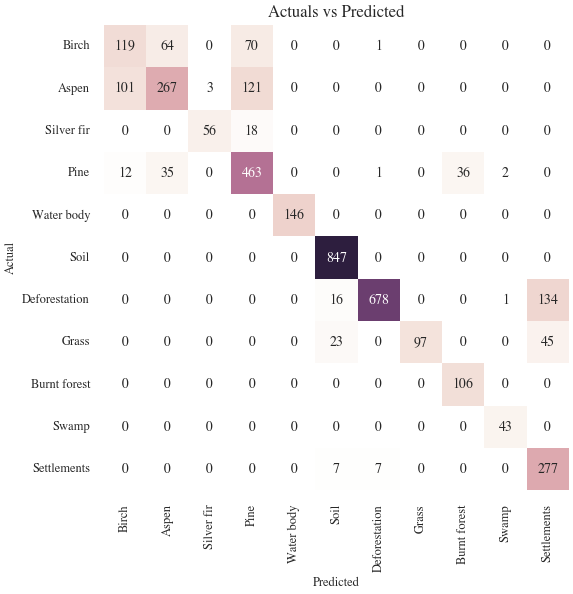

In [75]:
#metrics example
metrics_description(datavector_rf[0][2], datavector_rf[0][3])    

In [82]:
#metrics by prediction on test data by class
rf_class_metris = get_classes_metrics(datavector_rf)
rf_class_metris

,iteration,names,f1_scores,precision_list,recall
0,1,Birch,0.49,0.47,0.51
1,1,Aspen,0.62,0.54,0.73
2,1,Silver fir,0.84,0.76,0.95
3,1,Pine,0.76,0.84,0.69
4,1,Water body,1.00,1.00,1.00
5,1,Soil,0.97,1.00,0.95
6,1,Deforestation,0.89,0.82,0.99
7,1,Grass,0.74,0.59,1.00
8,1,Burnt forest,0.85,1.00,0.75
9,1,Swamp,0.97,1.00,0.93


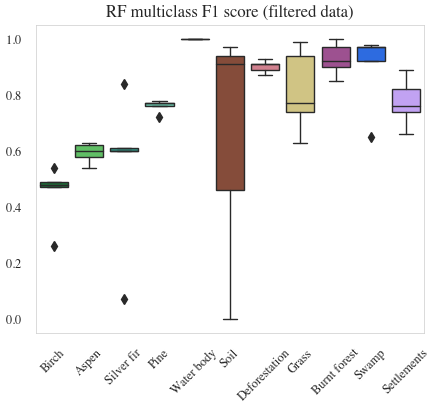

In [88]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = rf_class_metris['names'],
            y = rf_class_metris['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('RF multiclass F1 score (filtered data)')
plt.xticks(rotation=45)
plt.savefig('RF_multiclass_F1_score_filtered_data.png', dpi = 300)
plt.show()

## SVC

In [25]:
# svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# vector of 5 model iterations to evaluate average performance

datavector_svc = []
for i in range(5):
    svc_model = get_predictions(data = filtered_df_a,
                model = SVC(),
                param_grid = svc_grid)
    datavector_svc.append(svc_model)

Accuracy score: 77.85%
Precision score: 80.62%
Recall score: 77.85%
F1-Score: 72.24%
Kappa score: 74.50%


,names,f1_scores,precision_list,recall
0,Birch,0.62,0.58,0.66
1,Aspen,0.55,0.59,0.52
2,Silver fir,0.36,0.30,0.44
3,Pine,0.76,0.75,0.76
4,Water body,1.00,1.00,1.00
5,Soil,0.56,0.39,1.00
6,Deforestation,0.72,0.93,0.59
7,Grass,0.94,0.95,0.93
8,Burnt forest,0.99,0.99,1.00
9,Swamp,0.61,0.55,0.69


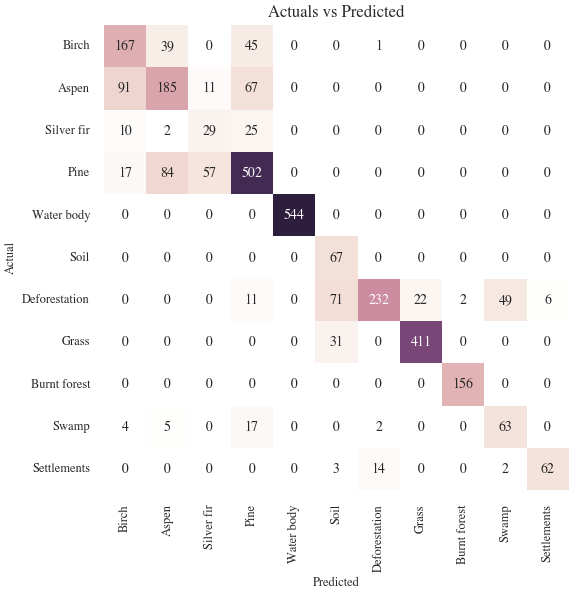

In [26]:
#metrics example for one iteration
metrics_description(datavector_svc[1][2], datavector_svc[1][3], confusion_matrix_on=True)   

In [27]:
#metrics by prediction on test data by class for each iteration
svc_class_metris = get_classes_metrics(datavector_svc)
svc_class_metris

,iteration,names,f1_scores,precision_list,recall
0,1,Birch,0.57,0.46,0.74
1,1,Aspen,0.56,0.69,0.47
2,1,Silver fir,0.41,0.37,0.46
3,1,Pine,0.73,0.72,0.73
4,1,Water body,1.00,1.00,1.00
5,1,Soil,0.24,0.38,0.17
6,1,Deforestation,0.97,1.00,0.93
7,1,Grass,0.83,0.75,0.93
8,1,Burnt forest,0.96,1.00,0.93
9,1,Swamp,0.77,0.78,0.75


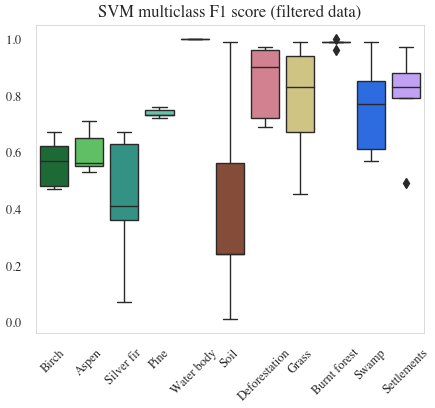

In [89]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = svc_class_metris['names'],
            y = svc_class_metris['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVM multiclass F1 score (filtered data)')
plt.xticks(rotation=45)
plt.savefig('SVC_multiclass_F1_score_filtered_data.png', dpi = 300)
plt.show()

## kNN

In [10]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}

# vector of 5 model iterations to evaluate average performance

datavector_knn = []

for i in range(5):
    knn_model = get_predictions(data = filtered_df_a,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn)
    datavector_knn.append(knn_model)

Accuracy score: 79.55%
Precision score: 81.57%
Recall score: 79.55%
F1-Score: 73.85%
Kappa score: 76.29%


,names,f1_scores,precision_list,recall
0,Birch,0.55,0.46,0.67
1,Aspen,0.56,0.63,0.51
2,Silver fir,0.35,0.28,0.45
3,Pine,0.66,0.72,0.61
4,Water body,1.00,1.00,1.00
5,Soil,0.93,0.95,0.90
6,Deforestation,0.90,0.98,0.84
7,Grass,0.85,0.76,0.98
8,Burnt forest,0.95,0.91,1.00
9,Swamp,0.59,0.42,1.00


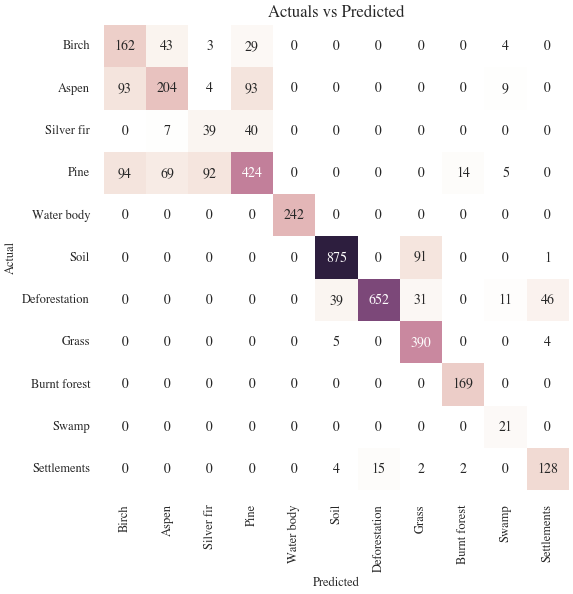

In [11]:
#metrics example
metrics_description(datavector_knn[0][2], datavector_knn[0][3])

In [12]:
#metrics by prediction on test data by class for each iteration
knn_class_metris = get_classes_metrics(datavector_knn)
knn_class_metris

,iteration,names,f1_scores,precision_list,recall
0,1,Birch,0.55,0.67,0.46
1,1,Aspen,0.56,0.51,0.63
2,1,Silver fir,0.35,0.45,0.28
3,1,Pine,0.66,0.61,0.72
4,1,Water body,1.00,1.00,1.00
5,1,Soil,0.93,0.90,0.95
6,1,Deforestation,0.90,0.84,0.98
7,1,Grass,0.85,0.98,0.76
8,1,Burnt forest,0.95,1.00,0.91
9,1,Swamp,0.59,1.00,0.42


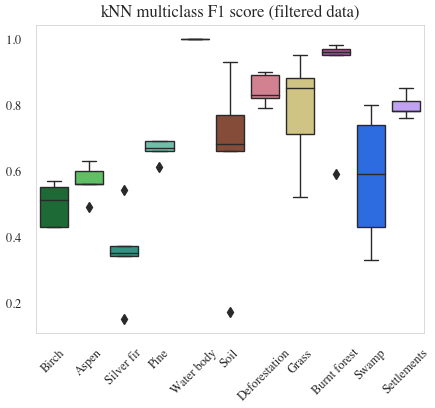

In [90]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = knn_class_metris['names'],
            y = knn_class_metris['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('kNN multiclass F1 score (filtered data)')
plt.xticks(rotation=45)
plt.savefig('kNN_multiclass_F1_score_filtered_data.png', dpi = 300)
plt.show()

# Wihtout filtering 

## Random forest

Accuracy score: 76.41%
Precision score: 77.31%
Recall score: 76.41%
F1-Score: 80.01%
Kappa score: 71.92%


,names,f1_scores,precision_list,recall
0,Birch,0.44,0.65,0.33
1,Aspen,0.62,0.54,0.73
2,Silver fir,0.80,0.79,0.81
3,Pine,0.80,0.78,0.83
4,Water body,1.00,1.00,1.00
5,Soil,0.72,0.56,1.00
6,Deforestation,0.92,0.85,1.00
7,Grass,0.80,1.00,0.67
8,Burnt forest,1.00,1.00,1.00
9,Swamp,0.78,1.00,0.64


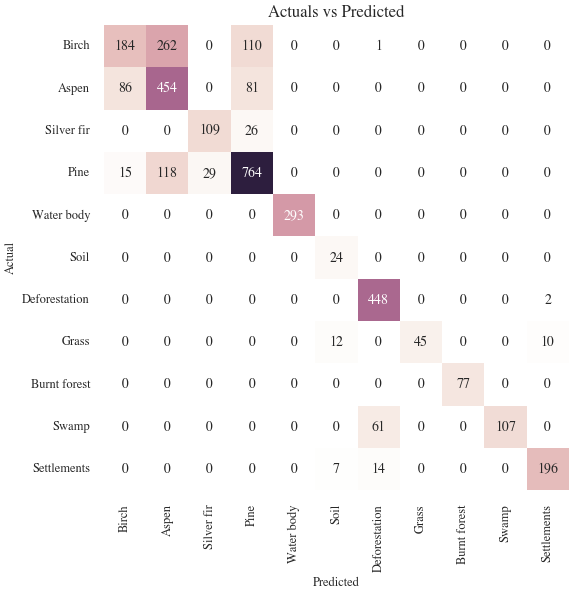

In [84]:
#for random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#get 5 model results on random train/test pairs

datavector_rf_wf = []
for i in range(5):
    rf_model_wf = get_predictions(data = df,
                model = RandomForestClassifier(),
                param_grid = random_grid)
    datavector_rf_wf.append(rf_model_wf)


Accuracy score: 76.41%
Precision score: 77.31%
Recall score: 76.41%
F1-Score: 80.01%
Kappa score: 71.92%


,names,f1_scores,precision_list,recall
0,Birch,0.44,0.65,0.33
1,Aspen,0.62,0.54,0.73
2,Silver fir,0.80,0.79,0.81
3,Pine,0.80,0.78,0.83
4,Water body,1.00,1.00,1.00
5,Soil,0.72,0.56,1.00
6,Deforestation,0.92,0.85,1.00
7,Grass,0.80,1.00,0.67
8,Burnt forest,1.00,1.00,1.00
9,Swamp,0.78,1.00,0.64


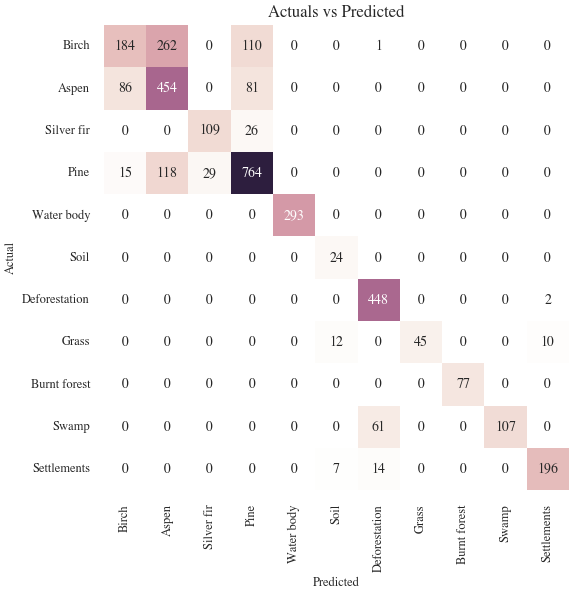

In [85]:
#metrics example
metrics_description(datavector_rf_wf[0][2], datavector_rf_wf[0][3])    

In [86]:
#metrics by prediction on test data by class
rf_class_metris_wf = get_classes_metrics(datavector_rf_wf)

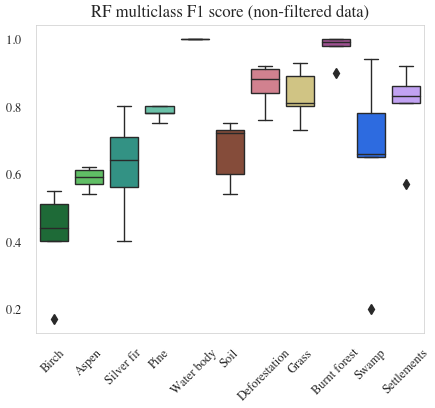

In [91]:
plt.figure(figsize=(5,4))
sns.boxplot(x = rf_class_metris_wf['names'],
            y = rf_class_metris_wf['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('RF multiclass F1 score (non-filtered data)')
plt.xticks(rotation=45)
plt.savefig('RF_multiclass_F1_score_nonfiltered_data.png', dpi = 300)
plt.show()

## SVC

In [21]:
#svc random grid

svc_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly']
             }

# vector of 5 model iterations to evaluate average performance on non-filtered data
datavector_svc_wf = []
for i in range(5):
    svc_model_wf = get_predictions(data = df,
                model = SVC(),
                param_grid = svc_grid)
    datavector_svc_wf.append(svc_model_wf) 

Accuracy score: 79.01%
Precision score: 83.75%
Recall score: 79.01%
F1-Score: 69.26%
Kappa score: 74.56%


,names,f1_scores,precision_list,recall
0,Birch,0.47,0.33,0.84
1,Aspen,0.58,0.72,0.49
2,Silver fir,0.58,0.41,0.97
3,Pine,0.81,0.86,0.76
4,Water body,1.00,1.00,1.00
5,Soil,0.17,0.13,0.24
6,Deforestation,0.98,0.97,0.99
7,Grass,0.73,0.86,0.64
8,Burnt forest,0.99,0.97,1.00
9,Swamp,0.39,0.44,0.34


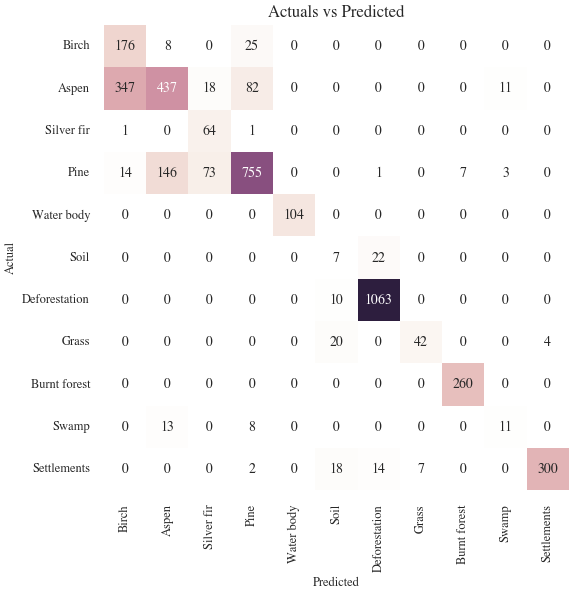

In [22]:
#metrics example
metrics_description(datavector_svc_wf[0][2], datavector_svc_wf[0][3])   

In [23]:
#metrics by prediction on test data by class for each iteration
svc_class_metris_wf = get_classes_metrics(datavector_svc_wf)
svc_class_metris_wf

,iteration,names,f1_scores,precision_list,recall
0,1,Birch,0.47,0.84,0.33
1,1,Aspen,0.58,0.49,0.72
2,1,Silver fir,0.58,0.97,0.41
3,1,Pine,0.81,0.76,0.86
4,1,Water body,1.00,1.00,1.00
5,1,Soil,0.17,0.24,0.13
6,1,Deforestation,0.98,0.99,0.97
7,1,Grass,0.73,0.64,0.86
8,1,Burnt forest,0.99,1.00,0.97
9,1,Swamp,0.39,0.34,0.44


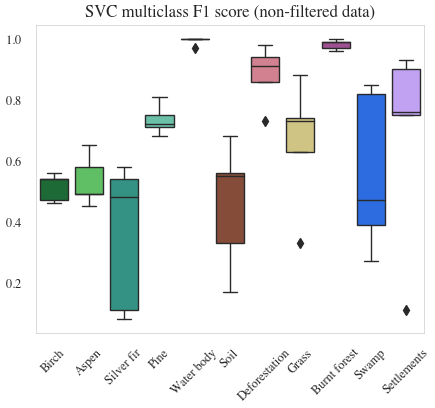

In [92]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = svc_class_metris_wf['names'],
            y = svc_class_metris_wf['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('SVC multiclass F1 score (non-filtered data)')
plt.xticks(rotation=45)
plt.savefig('SVC_multiclass_F1_score_nonfiltered_data.png', dpi = 300)
plt.show()

## kNN

In [16]:
#knn random grid
metric = ['euclidean','manhattan','chebyshev','minkowski']
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)] 
weights = ['uniform','distance']
random_grid_knn = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric
}

# vector of 5 model iterations to evaluate average performance on non-filtered data
datavector_knn_wf = []

for i in range(5):
    knn_model_wf = get_predictions(data = df,
                model = KNeighborsClassifier(),
                param_grid = random_grid_knn)
    datavector_knn_wf.append(knn_model_wf)

Accuracy score: 66.40%
Precision score: 81.35%
Recall score: 66.40%
F1-Score: 62.23%
Kappa score: 60.82%


,names,f1_scores,precision_list,recall
0,Birch,0.43,0.31,0.75
1,Aspen,0.52,0.68,0.43
2,Silver fir,0.47,0.31,0.95
3,Pine,0.65,0.91,0.51
4,Water body,1.00,1.00,1.00
5,Soil,0.91,0.94,0.88
6,Deforestation,0.76,0.94,0.64
7,Grass,0.23,0.13,1.00
8,Burnt forest,0.98,0.96,1.00
9,Swamp,0.16,0.09,1.00


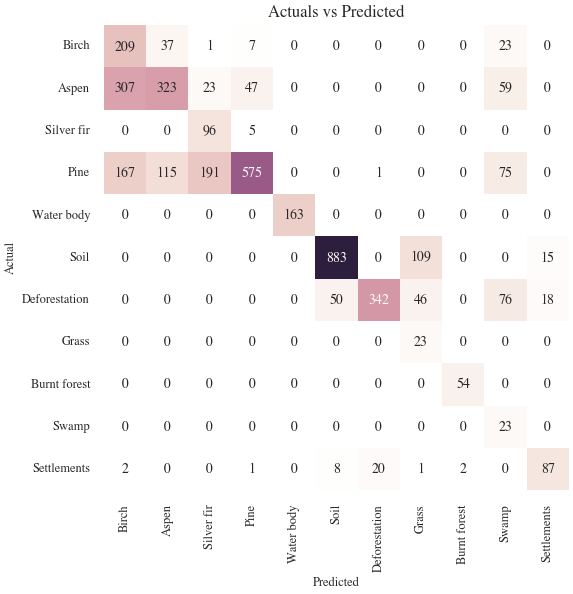

In [17]:
#metrics example
metrics_description(datavector_knn_wf[0][2], datavector_knn_wf[0][3])

In [18]:
#metrics by prediction on test data by class for each iteration on non-filtered data
knn_class_metris_wf = get_classes_metrics(datavector_knn_wf)

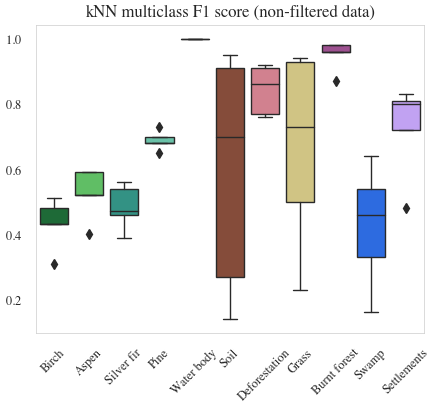

In [93]:
#f1 score plot
plt.figure(figsize=(5,4))
sns.boxplot(x = knn_class_metris_wf['names'],
            y = knn_class_metris_wf['f1_scores'], palette=colors)
plt.xlabel('')
plt.ylabel('')
plt.title('kNN multiclass F1 score (non-filtered data)')
plt.xticks(rotation=45)
plt.savefig('kNN_multiclass_F1_score_nonfiltered_data.png', dpi = 300)
plt.show()

# Statistics

In [96]:
def get_stat_results(dataframe):
    KW_results = scipy.stats.kruskal(*[group["f1_scores"].values for name, 
                      group in dataframe.groupby("model")])
    if KW_results[1]>0.05:
        return 'there is no significant difference between means'
    else: 
        return 'there is significant difference between means'

In [58]:
#get datasets with average metrics 

avg_svc_wf = get_metrics_average(datavector_svc_wf)
avg_svc = get_metrics_average(datavector_svc)

avg_svc_wf['model'] = 'svc_wf'
avg_svc['model'] = 'svc'
svcs = pd.concat([avg_svc, avg_svc_wf])


avg_knn_wf = get_metrics_average(datavector_knn_wf)
avg_knn = get_metrics_average(datavector_knn)

avg_knn_wf['model'] = 'knn_wf'
avg_knn['model'] = 'knn'
knns = pd.concat([avg_knn, avg_knn_wf])

avg_rf_wf = get_metrics_average(datavector_rf_wf)
avg_rf = get_metrics_average(datavector_rf)

avg_rf_wf['model'] = 'rf_wf'
avg_rf['model'] = 'rf'
rfs = pd.concat([avg_rf, avg_rf_wf])

In [97]:
#STATS RESULTS
print('RF on filtered and non-filtered data:', 
      get_stat_results(rfs))
print('SVM on filtered and non-filtered data:', 
      get_stat_results(svcs))
print('KNN on filtered and non-filtered data:', 
      get_stat_results(knns))

RF on filtered and non-filtered data: there is no significant difference between means
SVM on filtered and non-filtered data: there is no significant difference between means
KNN on filtered and non-filtered data: there is no significant difference between means
